# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.stats.stattools as st

from rdrobust import rdplot
from rdrobust import rdrobust
from scipy.stats import norm

# Methods

Methods for Identification 

In [2]:
def sign(x):
    """
    This function computes the sign of the given observation.

    Parameters
    ----------
    x : int
        The observation to compute the sign.

    Returns
    -------
    sign: int 
        Returns -1 if x is negative and 1 if nonnegative.
    """
    if x<0:
        return -1
    else:
        return 1

def treatment(x):
    """
    This function computes if an observation has received treatment.

    Parameters
    ----------
    x : int
        The observation to compute the treatment variable.

    Returns
    -------
    treatment: int 
        Returns 0 if observation x does not receive treatment and 1 if it does receive treatment.
    """
    if x<0:
        return 0
    else:
        return 1

def indicator(x):
    """
    This indicator function computes if an observation is within a distance of the threshold.

    Parameters
    ----------
    x : int
        The observation to compute the indicator value.

    Returns
    -------
    treatment: int 
        Returns 1 if observation x is within the distance and 0 if it is not.
    """
    if np.abs(x)<0.1:
        return 1
    else:
        return 0


def genT(X):
    """
    This function creates an array of treatment variables for a sample of observations.

    Parameters
    ----------
    X : arrray[int]
        The sample of observation to compute the treatment values for.

    Returns
    -------
    T: array[int]
        Returns an array with 1's and 0's for each observation depending on wether that observation received treatment.
    """
    T = {}
    for i in range(len(X)):
        T = np.append(T,treatment(X[i]))
    T = np.delete(T,0)
    return T
            


Methods for Generation of Outcomes: $Y_{i} = \mu(X_{i}) + \varepsilon_i$

$Y_{i}$ from Noak and Rothe 2023 donut RDD paper: 
$\newline \mu_N(x)=sign(x)*x^2-L*sign(x)((x-\delta*sign(x))^2-\delta^2*sign(x))*\boldsymbol{1}\{|x|<\delta\}$

In [3]:
def mu_noak(L,x):
    """
    This function generates the non-random part of outcome function with the DGP used by Noack and Rothe (NR) (2023).

    Parameters
    ----------
    L : int
        The parameter used by NR to define the level of misspecification L={0,10,20,30,40}.
    x : int
        The observation to compute the non-random outcome value for.

    Returns
    -------
    mu: int
        Returns the non-random part of the outcome value for that observation.
    """
    return sign(x)*np.power(x,2) - L*sign(x)*(np.power(x-0.1*sign(x),2)-np.power(0.1,2)*sign(x))*indicator(x)

def genY_noak(L,X,epsilon):
    """
    This function generates a sample of outcomes (Y_i's) with the DGP used by Noack and Rothe (NR) (2023).

    Parameters
    ----------
    L : int
        The parameter used by NR to define the level of misspecification L={0,10,20,30,40}.
    X : arrray[int]
        The sample of observation to compute the outcome values for.
    epsilon : arrray[int]
        The vector of random errors.

    Returns
    -------
    Y: arrray[int]
        Returns a vector with the outcome values.
    """
    Y = {}
    for i in range(len(X)):
        Y = np.append(Y,mu_noak(L,X[i]) + epsilon[i])
    Y = np.delete(Y,0)
    return Y

Basic linear outcomes ($Y_{i}$) plus simple treatment effect: $\quad \mu_{BL}(x)= \alpha + \beta x + \tau t$

In [4]:
def mu_basicLinear(tau,alpha,beta,x): 
    """
    This function generates the non-random part of the outcome function with a basic linear potential outcomes framework DGP.

    Parameters
    ----------
    tau : int 
        The size of the treatment effect.
    alpha: int
        The intercept parameter of the equation.
    beta: int
        The slope parameter of the equation.
    x : int
        The observation to compute the non-random outcome value for.

    Returns
    -------
    mu: int
        Returns the non-random part the outcome value.
    """
    return alpha + beta*x + tau*treatment(x)

def genY_basicLinear(tau,alpha,beta,X,epsilon):
    """
    This function generates a sample of outcomes (Y_i's) with a basic linear potential outcomes framework DGP.

    Parameters
    ----------
    tau : int 
        The size of the treatment effect.
    alpha: int
        The intercept parameter of the equation.
    beta: int
        The slope parameter of the equation.
    X : arrray[int]
        The sample of observation to compute the outcome values for.
    epsilon : arrray[int]
        The vector of random errors.

    Returns
    -------
    Y: arrray[int]
        Returns a vector with the outcome values.
    """
    Y = {}
    for i in range(len(X)):
        Y = np.append(Y,mu_basicLinear(tau,alpha,beta,X[i]) + epsilon[i])
    Y = np.delete(Y,0)
    return Y

# Sample Generation 

Seed Set-up

In [5]:
sd = np.random.default_rng(seed=42)
print(sd)

Generator(PCG64)


Generation of the Outcomes ($Y_{i}$) given the different DGP's

In [6]:
def genY(name, X, tau=0, L=0, alpha=0, beta=0):
    """
    This function generates a sample of observations from the given DGP.

    Parameters
    ----------
    name: string
        The name of the DGP to use.
    X : arrray[int]
        The sample of observation to compute the outcome values for.
    tau : int, Default value: 0
        The size of the treatment effect. For basic and basic linear model.
    L : int, Default value: 0
        The parameter used by NR to define the level of misspecification L={0,10,20,30,40}. For the Noack and Rothe model.
    alpha: int, Default value: 0
        The intercept parameter of the equation. For basic linear model.
    beta: int, Default value: 0
        The slope parameter of the equation. For basic linear model.

    Returns
    -------
    Y: arrray[int]
        Returns a vector with the outcome values.
    """
    epsilon = np.random.normal(0,0.5,len(X))
    if name == 'Noack':
        Y = genY_noak(L,X,epsilon)
    elif name == 'Basic Linear':
        Y = genY_basicLinear(tau,alpha,beta,X,epsilon)
    else:
        return NameError('Type of GDP is not recognised')
    return Y

In [7]:
def genOutlier(Y, X, name, nOutliers=1, delta=0.1):
    ''' 
    This function generates outliers based on different methods

    Parameters
    ----------
    Y : arrray[int]
        The sample of outcomes to generate the outlier(s) value(s) for.
    X : arrray[int]
        The sample of observation to generate the outlier(s) value(s) for.
    name : string 
        The name of the method to generate the ouotlier(s).
        Option values: Simple, Simple Outside.
    nOutlier : int
        The number of outliers to generate.
    delta : int  
        The size of the donut stripe.

    Returns
    -------
    Y : arrray[int]
        The sample of outcomes with the outlier(s) value(s).
    Outliers : arrray[int]
        An array with 1 if outlier and 0 is not. (Used for coloring the dots on scatter plots)
    '''
    Outliers = np.zeros_like(Y)
    # Simple generates to outlier(s) inside the donut stripe 
    if name == 'Simple':
        i = 0
        for j in range(nOutliers):
            found=True
            # Find first observation in the stripe and change outcome value to 2.5
            while(found):
                if (X[i] >= -delta) & (X[i] < 0):
                    Y[i] = 2.5
                    Outliers[i] = 1
                    found = False
                    i=i+1
                else: 
                    i=i+1  

    # Simple Outised generates to outlier(s) outside the donut stripe 
    if name == 'Simple Outside':
        i = 0
        for j in range(nOutliers):
            found=True
            # Find first observation just outside the stripe and change outcome value to 2.5
            while(found):
                if (X[i] >= -2*delta) & (X[i] < -delta):
                    Y[i] = 2.5
                    Outliers[i] = 1
                    found = False
                    i=i+1
                else: 
                    i=i+1    
    return Y, Outliers

Generation os the Sample $X_i$'s and $Y_i$'s

In [8]:

def genSample(name, n, tau=0,  alpha=0, beta=0,L=0,cutoff=0, outlier=False, outlierMethod='',nOutliers=1, printPlot=True):
    """
    Generate a sample for RDD analysis: running variables (X), outcomes (Y), and treatments (T)

    Parameters
    ----------
    name: string, Options: 'Noak', 'Basic', 'Basic Linear'
        The name of the DGP to use to generate the sample.
    n: int
        The size of the sample.
    tau : int, Default value: 0
        The size of the treatment effect. For basic and basic linear model.
    L : int, Default value: 0
        The parameter used by NR to define the level of misspecification L={0,10,20,30,40}. For the Noack and Rothe model.
    alpha: int, Default value: 0
        The intercept parameter of the equation. For basic linear model.
    beta: int, Default value: 0
        The slope parameter of the equation. For basic linear model.
    cutoff : int , Default value: 0
        The treshold of the running variable that determines treatment
    outlier: boolean
        True if sample should have an outlier(s)
    outlierMethod: string
        Name of the outlier generation method to use
    printPlot: boolean, Default value: False
        Defines if a plot is printed with the sample.

    Returns
    -------
    sample: DataFrame
        A dataframe object with the geneated Y (outcomes) and X (running variables) and given T (treatment variables)
    """
    X = np.random.uniform(-1+cutoff,1+cutoff,n)
    Y = genY(name, X, tau, L, alpha, beta)
    Outliers = np.zeros_like(Y)
    if outlier == True:
        Y, Outliers  = genOutlier(Y,X,outlierMethod,nOutliers)
    T = genT(X)

    # Create sample dataframe
    sample = pd.DataFrame({'Y': Y,'X': X,'T': T, 'Outlier': Outliers})
    sample.Y = sample.Y.astype(float)

    # Print plot
    if printPlot == True:
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["grey","red"])
        plt.scatter(X,Y,s=6,c=sample.Outlier, cmap=cmap)
        plt.xlabel('$X_i$')
        plt.ylabel('$Y_i$')
        
    return sample

Test Generate Sample Command

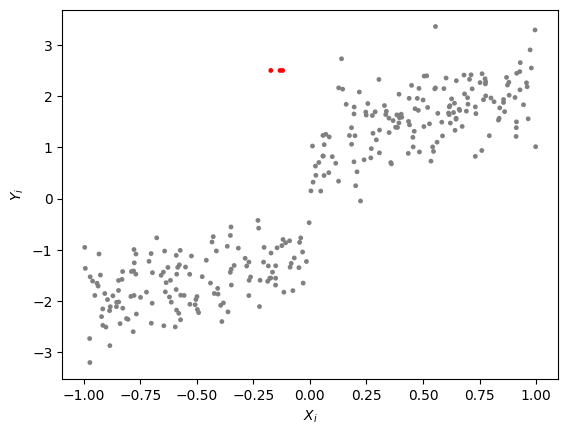

In [9]:
# Options are: 'Noak', 'Basic', 'Basic Linear'
sample = genSample('Basic Linear',300,tau=2,alpha=-1,beta=1,L=200,
                   outlier=True,outlierMethod='Simple Outside', nOutliers=3,printPlot=True)
#sample.to_csv('sample.csv')

In [10]:
def genExog(sample, intercept=False, jointFit=False):
    ''' 
    This method add prepares a sample to be used as exogenous variables in regression.

    Parameters
    ----------
    sample : DataFrame 
        The sample to prepare.
    intercept : boolean
        Determines if a intercept is added to the exogenous variables.

    Returns
    -------
    exog : DataFrame 
        Object with the prepared exogenous variables to be used for the regression.
    '''
    # Copy object and delete columns that are not exogenous variables.
    exog = sample.copy() 
    exog = exog.drop('Y',axis='columns')
    if jointFit is False:
        exog = exog.drop('T',axis='columns')
    exog = exog.drop('Outlier',axis='columns')
    # Add an intercept if requested
    if (intercept == True):
        exog = sm.add_constant(exog)
    
    return exog

def fit(name, sample, intercept, cutoff=0):
    ''' 
    This method will fit a regression based on the different estimation methods.

    Parameters
    ----------
    name : string
        The name of the estimation method to use.
        Opiton values : Robust Huber, Robust Tuckey, OLS, Donut.
    sample : DataFrame
        The sample to estimate the regression for.
    intercept : boolean 
        Determines if an intercept is added to the sample.
    cutoff : int
        The value of the threshold in the running variable.
    
    Returns
    -------
    res.params : object
        The parameters of the regression.
    '''
    # Prepare sample
    exog = genExog(sample,intercept)    
    # Estimate regression based on estimation method
    if (name == 'Robust Huber'):
        res = sm.RLM(sample.Y,exog.to_numpy(),M=sm.robust.norms.HuberT())
    
    elif (name == 'Robust Tuckey'):
        res = sm.RLM(sample.Y,exog.to_numpy(),M=sm.robust.norms.TukeyBiweight())

    elif (name == 'OLS'):
        res = sm.OLS(sample.Y,exog.to_numpy())

    elif (name == 'Donut'):
        sample = sample.loc[np.abs(sample.X-cutoff)>=0.1]
        exog = genExog(sample,intercept)
        res = sm.OLS(sample.Y,exog.to_numpy())
        
    else:
        return NameError('Type of Estimation method is not recognised')
    # Fit model and return parameters
    res = res.fit()
    return res

def splitFit (name,sample,cutoff,intercept):
    ''' 
    This method fits 2 distinct regressions on either side of the cutoff.

    Parameters
    ----------
    name : string
        The name of the estimation method to use.
        Opiton values : Robust Huber, Robust Tuckey, OLS, Donut.
    sample : DataFrame
        The sample to estimate the regression for.
    cutoff : int
        The value of the threshold in the running variable.
    intercept : boolean 
        Determines if an intercept is added to the sample.
    
    Returns
    -------
    params_below : object
        The parameters of the regression below the cutoff.
    params_above : object
        The parameters of the regression above the cutoff.
    '''
    # Split sample at cutoff
    sample_below = sample.loc[sample.X<=cutoff]
    sample_above = sample.loc[sample.X>cutoff]
    params_below = fit(name, sample_below,intercept=intercept).params
    params_above = fit(name, sample_above,intercept=intercept).params
    #print(params_below, params_above)
    return params_below, params_above

def jointFit(name,sample,cutoff=0):
    sample['XT'] = sample.apply(lambda row: row.X + row.T, axis=1)
    return fit(name,sample,True,cutoff,True)
    

def fitRD(name,sample,cutoff):
    ''' 
    This method estimates the treatment effects based on RDD.
    
    Parameters
    ----------
    name : string
        The name of the estimation method to use.
        Opiton values : Robust Huber, Robust Tuckey, OLS, Donut.
    sample : DataFrame
        The sample to estimate the regression for.
    cutoff : int
        The value of the threshold in the running variable. 

    Returns
    -------
    tau : int
        The estimated treatment effect.
    '''
    params_below, params_above  = splitFit(name,sample, cutoff, True)
    tau =  params_above.iloc[0] - params_below.iloc[0]
    return tau

def plotSplitFitComparison(sample, cutoff, name1, name2="", name3=""):
    ''' 
    This method plots a figure with the regession lines of the different estimation methods 

    Parameters
    ----------
    sample : DataFrame
        The sample to estimate the regression for.
    cutoff : int
        The value of the threshold in the running variable. 
    name1 : string
        The name of the estimation method to use.
        Opiton values : Robust Huber, Robust Tuckey, OLS, Donut.
    name2 : string ,Default value : ""
        The name of the estimation method to use.
        Opiton values : Robust Huber, Robust Tuckey, OLS, Donut.
    name3 : string ,Default value : ""
        The name of the estimation method to use.
        Opiton values : Robust Huber, Robust Tuckey, OLS, Donut.

    '''
    # Fit regressions and estimate ATE's
    params1_below, params1_above  = splitFit(name1,sample, cutoff, True)
    tau1 =  params1_above.iloc[0] - params1_below.iloc[0]
    if name2 != "":
        params2_below, params2_above = splitFit(name2,sample, cutoff, True)
        tau2 =  params2_above.iloc[0] - params2_below.iloc[0]

    if name3 != "":
        params3_below, params3_above = splitFit(name3,sample, cutoff, True)
        tau3 =  params3_above.iloc[0] - params3_below.iloc[0]

    
    # Plot scatter observations
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["grey","red"])
    plt.figure(figsize=(19,7))
    plt.scatter(sample.X,sample.Y,s=6,c=sample.Outlier,cmap=cmap)
    plt.scatter(sample.X,sample.Y,s=6,c=sample.Outlier,cmap=cmap)
    plt.xlabel('$X_i$')
    plt.ylabel('$Y_i$')

    # Plot regresion lines
    x_below = np.linspace(min(sample.X),cutoff,100)
    x_above = np.linspace(cutoff,max(sample.X),100)
    plt.plot(x_below,params1_below.iloc[0]+params1_below.iloc[1]*x_below, color ='b', linewidth=0.7)
    plt.plot(x_above,params1_above.iloc[0]+params1_above.iloc[1]*x_above, color ='b', linewidth=0.7, label=name1+' (ate: '+str(round(tau1,2))+')')
    if name2 != "":
        plt.plot(x_below,params2_below.iloc[0]+params2_below.iloc[1]*x_below, color ='g', linewidth=0.7)
        plt.plot(x_above,params2_above.iloc[0]+params2_above.iloc[1]*x_above, color ='g', linewidth=0.7, label=name2+' (ate: '+str(round(tau2,2))+')')
    if name3 != "":
        plt.plot(x_below,params3_below.iloc[0]+params3_below.iloc[1]*x_below, color ='purple', linewidth=0.7)
        plt.plot(x_above,params3_above.iloc[0]+params3_above.iloc[1]*x_above, color ='purple', linewidth=0.7, label=name3+' (ate: ' +str(round(tau3,2))+')')

    plt.legend()

In [11]:
param = fit('Robust Huber',sample,True)
print(param)

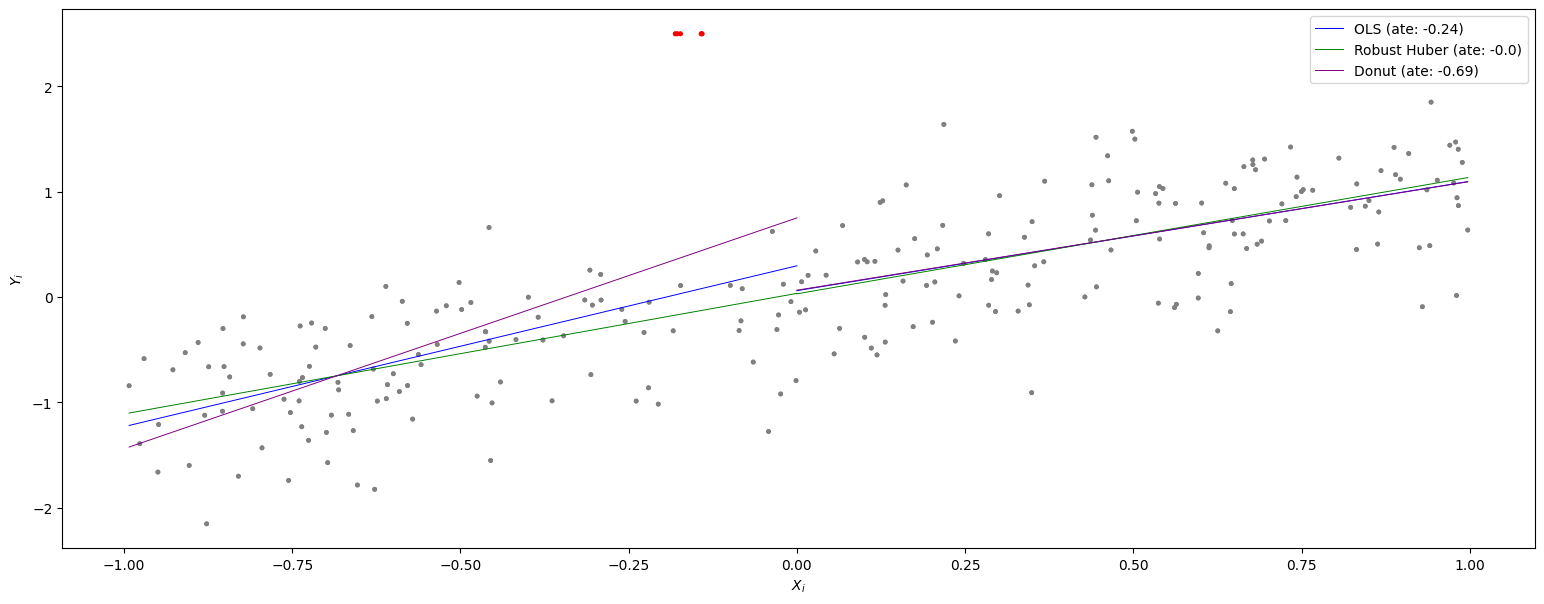

In [12]:
sample = genSample('Basic Linear',250,tau=0.3,alpha=-0.15,beta=1,L=200,
                   outlier=True,outlierMethod='Simple Outside', nOutliers=5,printPlot=False)
#sample['Xsq'] = sample.X**2
plotSplitFitComparison(sample,0,'OLS','Robust Huber','Donut')

In [13]:
sample

,Y,X,T,Outlier
0,-0.527824,-0.908935,0,0
1,0.488281,0.940573,1,0
2,-0.008735,0.596466,1,0
3,0.541897,0.436377,1,0
4,0.725069,0.504524,1,0
...,...,...,...,...
245,-1.276525,-0.042080,0,0
246,-1.392799,-0.976390,0,0
247,-1.825469,-0.627382,0,0
248,1.104366,0.463415,1,0


In [14]:
sample.apply(lambda row: row.X * row.T, axis=1)

,Y,X,T,Outlier
0,0.479757,0.826163,-0.000000,-0.0
1,0.459264,0.884678,0.940573,0.0
2,-0.005210,0.355772,0.596466,0.0
3,0.236472,0.190425,0.436377,0.0
4,0.365814,0.254544,0.504524,0.0
...,...,...,...,...
245,0.053716,0.001771,-0.000000,-0.0
246,1.359915,0.953338,-0.000000,-0.0
247,1.145267,0.393608,-0.000000,-0.0
248,0.511780,0.214754,0.463415,0.0


In [15]:
#rdrobust(sample.Y,sample.X,p=1)
#rdplot(sample.Y,sample.X,p=1)

# Simulation of Treatment Effects Estimation

In [16]:
n = 1000
L = np.array([0,10,20,30,40])
tau = 2
a = -1
b = 1

In [17]:
def simulation(r,nameSample,n,tau=0,  alpha=0, beta=0, L=0, cutoff=0,b=1, outlier=False, outlierMethod='', nOutliers=0):
    """
    Run simulation analysis for RDD: Generates a sample r times and returns the results of each sample
    
    Parameters
    ----------
    r: int 
        The number of replications.
    nameSample: string, Options: 'Noak', 'Basic Linear'
        The name of the DGP to use to generate the sample.
    n: int
        The size of the sample.
    tau : int , Default value: 0
        The size of the treatment effect. For basic and basic linear model.
    L : int, Default value: 0
        The parameter used by NR to define the level of misspecification L={0,10,20,30,40}. For the Noack and Rothe model.
    cutoff : int , Default value: 0
        The treshold of the running variable that determines treatment
    b : int , Default value: 1
        Represent the bandwidth selected
    alpha: int, Default value: 0
        The intercept parameter of the equation. For basic linear model.
    beta: int, Default value: 0
        The slope parameter of the equation. For basic linear model.
    
    Returns
    -------
    sample: DataFrame
        A dataframe object with the results from the simulation. 
        For each smaple it returns the estimated Treatment Effects (TE), bandwidth (H).
    """ 
    # Creat empty output arrays
    t_OLS = {}
    t_RH = {}
    t_RT = {}
    t_D = {}

    # Generate sample and fit models r times
    for i in range(r):
        # Generate sample
        sample = genSample(nameSample,n,tau, alpha, beta,L,cutoff,outlier, outlierMethod, nOutliers, False)
        # Select sample to be used according to bandwidth
        sample = sample.loc[np.abs(sample.X-cutoff)<=b]
        # Estimate models
        t_OLS = np.append(t_OLS, fitRD('OLS',sample,0))
        t_RH = np.append(t_RH, fitRD('Robust Huber',sample,0))
        t_RT = np.append(t_RT, fitRD('Robust Tuckey',sample,0))
        t_D = np.append(t_D, fitRD('Donut',sample,0))
    
    # Adjust the format of the arrays (delete empty first cell)
    t_OLS = np.delete(t_OLS,0)
    t_RH = np.delete(t_RH,0)
    t_RT = np.delete(t_RT,0)
    t_D = np.delete(t_D,0)

    # Create dataframe with simultation results
    simulationResults = pd.DataFrame({'OLS':t_OLS, 'Huber':t_RH, 'Tuckey':t_RT, 'Donut':t_D})
    return simulationResults

In [18]:
simulationResults = simulation(10,'Basic Linear',300,tau=2,alpha=-1,beta=1,outlier=False)

In [19]:
def compRMSE(simRes):
    return [sm.tools.eval_measures.rmse(simRes.OLS,2), sm.tools.eval_measures.rmse(simRes.Huber,2), 
    sm.tools.eval_measures.rmse(simRes.Tuckey,2), sm.tools.eval_measures.rmse(simRes.Donut,2)]

In [20]:
def simulations(r,name,n,tau,alpha,beta,cutoff=0,L=0):
    ''' 
    This method runs various simulations and return the results from all different simulations

    Parameters
    ----------
    r: int 
      The number of repetitions
    name: string
      The name of the DGP 
    tau : int , Default value: 0
        The size of the treatment effect. For basic and basic linear model.
    L : int, Default value: 0
        The parameter used by NR to define the level of misspecification L={0,10,20,30,40}. For the Noack and Rothe model.
    alpha: int, Default value: 0
        The intercept parameter of the equation. For basic linear model.
    beta: int, Default value: 0
        The slope parameter of the equation. For basic linear model.
    cutoff : int , Default value: 0
        The treshold of the running variable that determines treatment
      
    Returns
    -------
    Results:Dataframe 
      Object with the means, st.var and rmse of the various simulations
    
    '''
    # Run Simulations
    simRes1 = simulation(r,name,n,tau,alpha,beta,cutoff=cutoff,outlier=False)
    simRes2 = simulation(r,name,n,tau,alpha,beta,cutoff=cutoff,outlier=True, outlierMethod='Simple Outside', nOutliers=1)
    simRes3 = simulation(r,name,n,tau,alpha,beta,cutoff=cutoff,outlier=True, outlierMethod='Simple Outside', nOutliers=2)
    simRes4 = simulation(r,name,n,tau,alpha,beta,cutoff=cutoff,outlier=True, outlierMethod='Simple', nOutliers=1)
    simRes5 = simulation(r,name,n,tau,alpha,beta,cutoff=cutoff,outlier=True, outlierMethod='Simple', nOutliers=2)
    simRes6 = simulation(r,'Noack',n,tau,L=40,cutoff=cutoff,b=0.5,outlier=False)

    # Compute Root Mean Squared Error
    rmse1 = compRMSE(simRes1)
    rmse2 = compRMSE(simRes2)
    rmse3 = compRMSE(simRes3)
    rmse4 = compRMSE(simRes4)
    rmse5 = compRMSE(simRes5)
    rmse6 = compRMSE(simRes6)

    # Create dataframe with results
    result_1 = pd.DataFrame({'Mean':simRes1.mean(),'St. Dev.': simRes1.std(), 'RMSE':rmse1})
    result_2 = pd.DataFrame({'Mean':simRes2.mean(),'St. Dev.': simRes2.std(), 'RMSE':rmse2})
    result_3 = pd.DataFrame({'Mean':simRes3.mean(),'St. Dev.': simRes3.std(), 'RMSE':rmse3})
    result_4 = pd.DataFrame({'Mean':simRes4.mean(),'St. Dev.': simRes4.std(), 'RMSE':rmse4})
    result_5 = pd.DataFrame({'Mean':simRes5.mean(),'St. Dev.': simRes5.std(), 'RMSE':rmse5})
    result_6 = pd.DataFrame({'Mean':simRes6.mean(),'St. Dev.': simRes6.std(), 'RMSE':rmse6})

    # Create one dataframe with all results
    multiCol1 = pd.MultiIndex.from_arrays([['Scenario 1', 'Scenario 1', 'Scenario 1',
                                           'Scenario 2', 'Scenario 2', 'Scenario 2',
                                           'Scenario 3', 'Scenario 3', 'Scenario 3'], 
                                           ['Mean','St.Var','RMSE',
                                            'Mean','St.Var','RMSE',
                                            'Mean','St.Var','RMSE',]])
    multiCol2 = pd.MultiIndex.from_arrays([['Scenario 4', 'Scenario 4', 'Scenario 4',
                                           'Scenario 5', 'Scenario 5', 'Scenario 5',
                                           'Scenario 6', 'Scenario 6', 'Scenario 6'], 
                                            ['Mean','St.Var','RMSE',
                                            'Mean','St.Var','RMSE',
                                            'Mean','St.Var','RMSE']])
    row = ['OLS', 'Huber', 'Tuckey', 'Donut']
    Results1 = pd.DataFrame(np.transpose(np.array([simRes1.mean(),simRes1.std(),rmse1, 
                                                  simRes2.mean(),simRes2.std(),rmse2, 
                                                  simRes3.mean(),simRes3.std(),rmse3])),
                                                    columns=multiCol1, index=row)
    
    Results2 = pd.DataFrame(np.transpose(np.array([simRes4.mean(),simRes4.std(),rmse4, 
                                                  simRes5.mean(),simRes5.std(),rmse5, 
                                                  simRes6.mean(),simRes6.std(),rmse6])),
                                                    columns=multiCol2, index=row)
    return Results1 , Results2

In [22]:
r = 10
n = 300

results1, results2 = simulations(r,'Basic Linear',n,tau=2,alpha=-1,beta=1,cutoff=0)

In [23]:
# Print results to latex tables
print(results1.to_latex(float_format="{:.3f}".format, multicolumn_format='c'))
print(results2.to_latex(float_format="{:.3f}".format, multicolumn_format='c'))
print('r = ' +str(r)+' , n = '+str(n))

\begin{tabular}{llllllllll}
\toprule
 & \multicolumn{3}{c}{Scenario 1} & \multicolumn{3}{c}{Scenario 2} & \multicolumn{3}{c}{Scenario 3} \\
 & Mean & St.Var & RMSE & Mean & St.Var & RMSE & Mean & St.Var & RMSE \\
\midrule
OLS & 2.036 & 0.094 & 0.096 & 1.944 & 0.124 & 0.131 & 1.858 & 0.108 & 0.176 \\
Huber & 2.038 & 0.105 & 0.107 & 2.010 & 0.133 & 0.127 & 1.964 & 0.093 & 0.095 \\
Tuckey & 2.038 & 0.102 & 0.104 & 2.027 & 0.137 & 0.133 & 1.999 & 0.091 & 0.086 \\
Donut & 2.050 & 0.111 & 0.117 & 1.874 & 0.141 & 0.184 & 1.799 & 0.130 & 0.236 \\
\bottomrule
\end{tabular}

\begin{tabular}{llllllllll}
\toprule
 & \multicolumn{3}{c}{Scenario 4} & \multicolumn{3}{c}{Scenario 5} & \multicolumn{3}{c}{Scenario 6} \\
 & Mean & St.Var & RMSE & Mean & St.Var & RMSE & Mean & St.Var & RMSE \\
\midrule
OLS & 1.911 & 0.126 & 0.149 & 1.840 & 0.092 & 0.183 & -0.191 & 0.139 & 2.195 \\
Huber & 1.981 & 0.143 & 0.137 & 1.979 & 0.097 & 0.094 & -0.183 & 0.143 & 2.188 \\
Tuckey & 2.002 & 0.143 & 0.136 & 2.024 & 0.0

In [ ]:
def niceHist(serie, JB = False):
    '''
    This function plot the histogram of the serie with a pdf of a normal function with equal mean and st.dev

    Parameters
    ----------
    serie: arr[int]
        the serie to plot the histogram of
    JB: boolean, default:False
        Determine if the Jarque-Bera statistics are printed
    '''
    # print jarque-bera statistics
    if JB == True:
        print('Jarque-Bera : '+ st.jarque_bera(serie))

    # Plot the histogram    
    hist = plt.hist(serie, bins=60, density=True)
    plt.title("Fit Values: {:.2f} and {:.2f}".format(np.mean(serie), np.std(serie)))

    # Plot the matching normal PDF.
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100) 
    p = norm.pdf(x, np.mean(serie), np.std(serie))
    plt.plot(x, p, 'k', linewidth=2)

In [ ]:
niceHist(R.Donut, True)

NameError: name 'simRes1' is not defined